# Max-Cut QAOA for n = 2
## Quantum Approximate Optimization Algorithm for n = 2 vertices
### Understanding how the QAOA works using 2-vertex graph so solve the max-cut problem
## -----------------------------------------------------------------------------------------------------------------------------------
#### Import all relavent libraries/packages to run the algorithm

In [1]:
from qiskit import *
from scipy import optimize as opt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

#### For n = 2 connected unweighted graph there is only one possible type of graph that would work for a max-cut problem as shown below:

/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


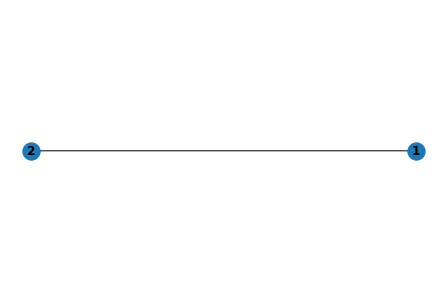

In [2]:
G = nx.Graph()
G.add_nodes_from([1,2])
G.add_edges_from([(1,2)])

nx.draw_shell(G, with_labels=True, font_weight='bold')
plt.show()

#### Now we have to construct the quantum circuit for the max-cut problem. The classical  Max-Cut problem is :
#### $ C_{<i,j>} = max \sum \frac{1}{2} (1 - \sigma_i^Z\sigma_j^Z)$
#### However, there is only 2 vertices in this particular problem, the problem reduces to :
#### $ C_{<i,j>} = max  \frac{1}{2} (1 - \sigma_1^Z\sigma_2^Z)$
#### The sigma notation is indicate if a particula vertex is on the $S$ or the $\neg S$ of the graph where if it is the value of  $\sigma_i^Z$ = -1 else it is 1
#### Hence the quantum circuit converts into :

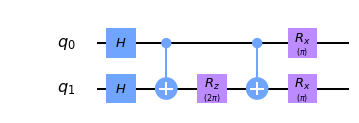

In [3]:
# Initialize the circuit
circuit = QuantumCircuit(2)
# Set the std params for the RX() gate
beta = np.pi # range of betas for Rx is 0 <= B <= pi
gamma = np.pi * 2 # range of gammas for Rz 0 <= g <= 2pi
# Declare hyperparams
hyperparams = [gamma, beta]

## MAX-CUT circuit for 2-vertices problem
circuit.h(0)
circuit.h(1)

# declare the hamiltonian function
Cost_hamiltonian = QuantumCircuit(2)
Cost_hamiltonian.cx(0,1)
Cost_hamiltonian.rz(hyperparams[0],1)
Cost_hamiltonian.cx(0,1)
Cost_hamiltonian.rx(hyperparams[1],0)
Cost_hamiltonian.rx(hyperparams[1],1)

circuit += Cost_hamiltonian

# Draw the ciruit out
circuit.draw(output='mpl')

#### We will never know the results unless the measurement is made :

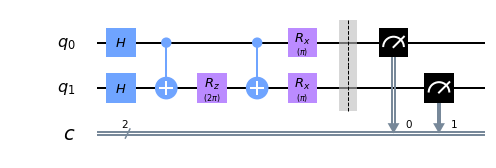

In [4]:
# Create a Quantum Circuit
meas = QuantumCircuit(2, 2)
meas.barrier(range(2))
# map the quantum measurement to the classical bits
meas.measure(range(2),range(2))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = circuit
qc += meas
#drawing the circuit
qc.draw(output='mpl')

#### Now, we need to import the backend from the library in this case a simulator:

In [5]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

#### Run the ciruit and finally plot the histogram:

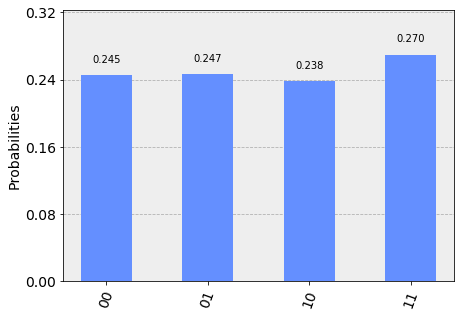

In [6]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

#### However, we did not get the result we expected since all possible qubit combinations came with equal probablities. For this particular problem we know that each vertex must lie on opposite sides of the cut in order to maximize the Cost.

#### Now we have to employ the use of optimizers to tune the values of the hyperparamters to minimize the Cost, hence we declare a get cost function which returns the $<H_c>$ :

In [7]:
def get_cost(counts, no_of_shots):
    cost = 0.0
    c = 0
    for qubit_string , expt in counts.items():
        if qubit_string[0] == qubit_string[1]:
            c = 0
        else:
            c = 1
        cost += c * (expt / no_of_shots)
    return cost

#### Then we will also define a function that runs the circuits and returns the $<H_c>$ of the problem so that we can use the function in the Scipy.Optimize.minimize function :

##### Notice that we return the cost as 1 - $<H_c>$ so that we can minimize the Cost  Expectation value

In [8]:
def run_circuit_and_get_cost(hyperparams):
    # Initialize the circuit
    circuit = QuantumCircuit(2)
    ## MAX-CUT circuit for 2-vertices problem
    circuit.h(0)
    circuit.h(1)

    # declare the hamiltonian function
    Cost_hamiltonian = QuantumCircuit(2)
    Cost_hamiltonian.cx(0,1)
    Cost_hamiltonian.rz(hyperparams[0],1)
    Cost_hamiltonian.cx(0,1)
    Cost_hamiltonian.rx(hyperparams[1],0)
    Cost_hamiltonian.rx(hyperparams[1],1)

    circuit += Cost_hamiltonian

    
    # Create a Quantum Circuit
    meas = QuantumCircuit(2, 2)
    meas.barrier(range(2))
    # map the quantum measurement to the classical bits
    meas.measure(range(2),range(2))

    # The Qiskit circuit object supports composition using
    # the addition operator.
    qc = circuit
    qc += meas

    # Use Aer's qasm_simulator
    backend_sim = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job_sim = execute(qc, backend_sim, shots=1024)

    # Grab the results from the job.
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    
    return 1 - get_cost(counts, no_of_shots=1024)

#### We can finally optimize the hyperparameters! We shall use COBYLA algorithm for this optimization (we will exploring other possible optimizers in the future) 
#### Set the hyperparamters to a random value of your choice and run the optimizer!

In [9]:
hyperparamters = [0.4, 0.7]
#hyperp_bounds = opt.Bounds([0, np.pi *2], [0, np.pi])

res = opt.minimize(run_circuit_and_get_cost,hyperparamters,tol= 1e-3, method='COBYLA')

#### We have managed to succesfully optimize the circuit with the hyperparamter values for Gamma = 1.4773 and Beta = 2.3777. 

In [10]:
print(res)
hyperparams = res.x

     fun: 0.0048828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 25
  status: 1
 success: True
       x: array([1.49010546, 2.29703297])


#### All that is left is too run the circuit again with the optimized hyperparamters and see the results.

#### From the the histogram below, it is evident that we managed to get the right answer where the vertices of the graph are to be in opposite sides of the cut  $|01>$  or  $|10>$ in order to maximize the cut.

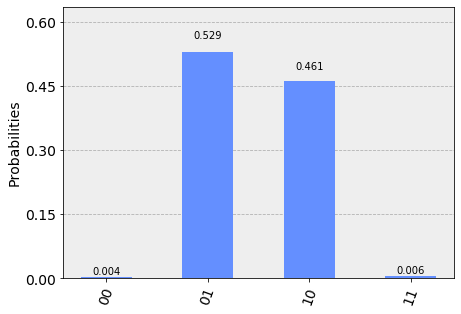

In [11]:
# Initialize the circuit
circuit = QuantumCircuit(2)
## MAX-CUT circuit for 2-vertices problem
circuit.h(0)
circuit.h(1)

# declare the hamiltonian function
Cost_hamiltonian = QuantumCircuit(2)
Cost_hamiltonian.cx(1,0)
Cost_hamiltonian.rz(hyperparams[0],0)
Cost_hamiltonian.cx(1,0)
Cost_hamiltonian.rx(hyperparams[1],0)
Cost_hamiltonian.rx(hyperparams[1],1)

circuit += Cost_hamiltonian

    
# Create a Quantum Circuit
meas = QuantumCircuit(2, 2)
meas.barrier(range(2))
# map the quantum measurement to the classical bits
meas.measure(range(2),range(2))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = circuit
qc += meas

# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

from qiskit.visualization import plot_histogram
plot_histogram(counts)